## Todo


- ✔️ check other out_quants (higher frequencies, damping ratios, etc.)
- ✔️ find good epsilon for zetas and damp_freqs
- ✔️ evaluate intp_errors, exceed and undershot for frf, zetas, damp_freqs
- ✔️ check most recent ale samples manually to see what's going on

- ✔️ also do something similar for nearestND interpolator
- ✔️increase number of propositions for add_mass and b and ???
    - ✔️damp_freqs is sensitive to add_mass (1 proposition), ice_mass (1 proposition), (b 1 and t 2)
    - ✔️zetas is sensititive to zeta (and dD but that is aleatory) (4 propositions)
    - ✔️frfs is sensitive to all of them depending on frequency line and response dof
    - ✔️-> should have two propositions on add_mass (40,50)
- ✔️ estimate runtime for all 13717 aleatory samples with nearest and rbf interpolators and decide 
  - ✔️ whether performance can be improved further
  - ✔️ whether to implement distributed imperfection estimation
  - ✔️ 1 sample around 30 s -> 3062 samples -> 1531 minutes -> 26 hours (114 hours -> 5 days)
  - ✔️ Vectorize wrapper: 1 sample around 12 s @ 4 CPUs (rbf) -> 3062 samples -> 612 (2743) minutes -> 10:30 (45) hours (2 days) ->  (2078 out_quants -> 659 days @ 1 node, 32 days @ 20 nodes)

- ✔️ test val_samp_prim
- batch process already propagated ale samples

- for exemplary ret_names do
  - estimate_imp (with rbf)
  - optimize_inc
  - draw plots
- test repeat with nearest and compare
- repeat for all ret_names and selected ret_inds
- finish remaining ale samples

In [ ]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import logging
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats.qmc

import ray

from uncertainty.polymorphic_uncertainty import *
from uncertainty.data_manager import DataManager

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

In [ ]:
from UQ_Modal_Beam import mapping_function, mapping_pass, test_interpolation, vars_definition

##### Uncertainty Modeling

In [ ]:
vars_ale, vars_epi, arg_vars = vars_definition()

##### Sampling

In [4]:
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 13717 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 729 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True
result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/'

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'))

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz


## Evaluate RBF interpolation parameters

In [5]:
ret_name = ['damp_freqs','zetas','frf'][1]
if ret_name == 'frf':
    ret_ind = {'frequencies':126, 'space':1}
else:
    ret_ind = {'modes':13}
    
ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'        
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

poly_uq.load_state(os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz'))
if ret_name == 'damp_freqs':
    poly_uq.out_valid = [np.nanmin(poly_uq.out_samp),np.nanmax(poly_uq.out_samp)]

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/zetas-13/polyuq_prop.npz


In [6]:
plt.close('all')
# %%snakeviz -t
if True:
    logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
    logger.setLevel(level=logging.DEBUG)
    poly_uq.N_mcs_ale=np.random.randint(20,3062)
    poly_uq.estimate_imp(
        interp_fun='rbf',
        opt_meth='genetic',
        plot_res=False,
        plot_intp=False,
        intp_err_warn = 0,
        extrp_warn = 0,
        start_ale = poly_uq.N_mcs_ale - 2,
        kernel='gaussian',
        epsilon={'frf':4,'zetas':2,'damp_freqs':2}[ret_name]
    )
    print([var for var in poly_uq.vars_ale if var.primary] + list(poly_uq.vars_imp))
    for n_ale in range(poly_uq.N_mcs_ale - 2,poly_uq.N_mcs_ale):
        for i_hyc in range(len(poly_uq.imp_hyc_foc_inds)):
            print(n_ale, i_hyc)
            print(poly_uq.val_samp_prim[n_ale,i_hyc,:,0])
            print(poly_uq.val_samp_prim[n_ale,i_hyc,:,1])

#     poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
    


KeyboardInterrupt



Error in callback <function flush_figures at 0x7f6d5c68f5b0> (for post_execute):



KeyboardInterrupt



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
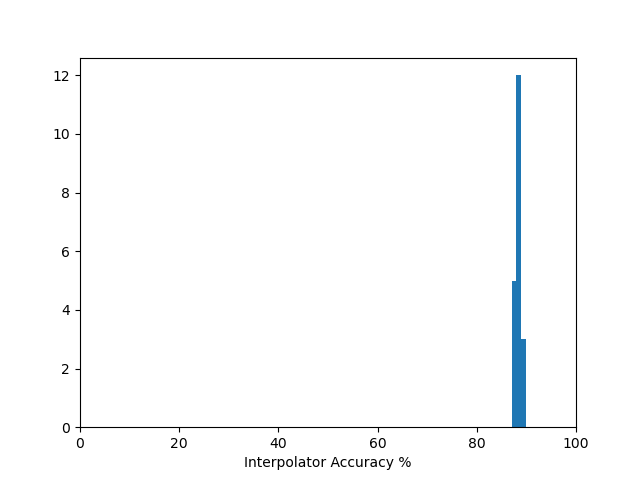

In [113]:
# intp_previous4 = np.copy(poly_uq.intp_errors)
# exceed_previous4 = np.copy(poly_uq.intp_exceed)
# undershot_previous4 = np.copy(poly_uq.intp_undershot)
plt.figure()
plt.hist(100-poly_uq.intp_errors*100, bins=np.arange(101))
# plt.hist(100-intp_previous1*100, bins=np.arange(101))
# plt.hist(100-intp_previous2*100, bins=np.arange(101))
plt.xlabel("Interpolator Accuracy %")
plt.xlim((0,100))
plt.show()
# print(poly_uq.intp_exceed[1] / poly_uq.intp_exceed[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# if poly_uq.intp_undershot[0]:
#     print(poly_uq.intp_undershot[1] / poly_uq.intp_undershot[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(poly_uq.imp_foc)
# print(exceed_previous1[1] / exceed_previous1[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(undershot_previous1[1] / undershot_previous1[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(exceed_previous2[1] / exceed_previous2[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)
# print(undershot_previous2[1] / undershot_previous2[0] / (poly_uq.out_valid[1] - poly_uq.out_valid[0]) * 100)

In [10]:
ray.shutdown()
ray.init(address='auto', _redis_password='5241590000000000')

all_intp_errors = {'damp_freqs':[None for _ in range(30)],'zetas':[None for _ in range(30)],'frf':[None for _ in range(30)]}
all_intp_exceed = {'damp_freqs':[None for _ in range(30)],'zetas':[None for _ in range(30)],'frf':[None for _ in range(30)]}
all_intp_undershot = {'damp_freqs':[None for _ in range(30)],'zetas':[None for _ in range(30)],'frf':[None for _ in range(30)]}

2023-01-27 09:50:08,562	INFO worker.py:1342 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-01-27 09:50:08,566	INFO worker.py:1519 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


In [ ]:


# rets = test_interpolation('damp_freqs',{'modes':11},754)
# print(rets)

# asffdafgdf


@ray.remote
def sub_test(i, ret_name, i_n, N_mcs):
    if ret_name == 'frf':
        ret_ind = {'frequencies':i_n//2, 'space':i_n%2}
    else:
        ret_ind = {'modes':i_n}
    return i, ret_name, i_n, *test_interpolation(ret_name, ret_ind, N_mcs)

all_inds ={'damp_freqs':[],'zetas':[],'frf':[]}
all_MCS ={'damp_freqs':[],'zetas':[],'frf':[]}
futures = []
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        n = 126*2
    else:
        n=14
        
    inds = np.random.randint(0,n,30)
    N_mcs = np.random.randint(100,3062,30)
    all_inds[ret_name] = inds
    all_MCS[ret_name] = N_mcs
    for i in range(30):
        if all_intp_errors[ret_name][i] is not None: continue
        futures.append(sub_test.remote(i, ret_name, inds[i], N_mcs[i]))

futures = set(futures)

In [121]:
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=30)
    try:
        ret_sets = ray.get(ready)
        size_before = len(futures)
        for i, ret_name, ind, intp_errors, intp_exceed, intp_undershot in ret_sets:
        #     assert all_intp_errors[ret_name][i] is None
            all_intp_errors[ret_name][i] = intp_errors
        #     assert all_intp_exceed[ret_name][i] is None
            all_intp_exceed[ret_name][i] = intp_exceed
        #     assert all_intp_undershot[ret_name][i] is None
            all_intp_undershot[ret_name][i] = intp_undershot
            
        futures.difference_update(ready)
        print(f"Finished {len(ready)} samples. Remaining {len(futures)} samples. (before {size_before})")
    except Exception as e:
        print(e)
        pass
    if len(futures) == 0:
        break

Finished 10 samples. Remaining 10 samples. (before 20)
Finished 10 samples. Remaining 0 samples. (before 10)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
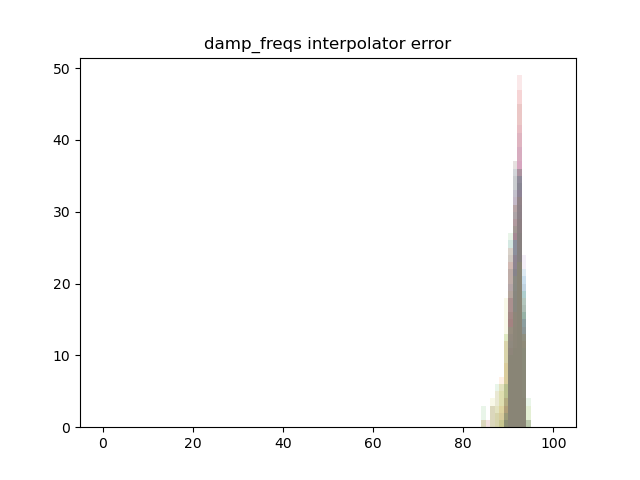

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
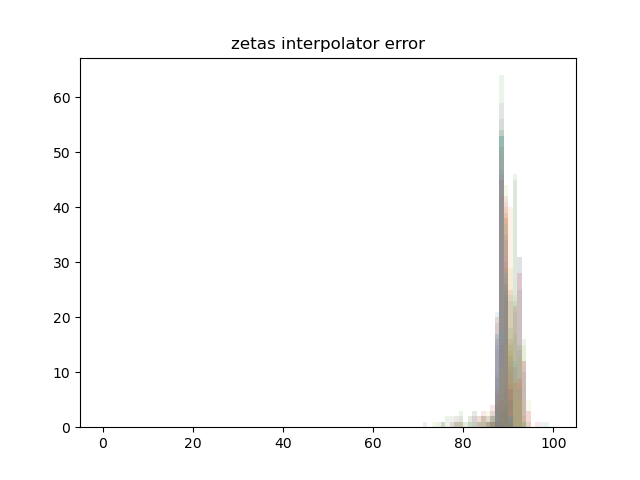

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
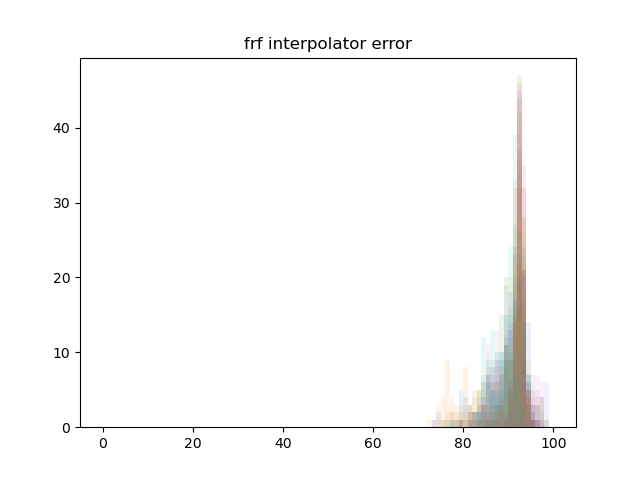

In [123]:
plt.close('all')
for ret_name in ['damp_freqs','zetas','frf']:
    '''
    draw 30 histograms of intp_errors (overlaying transparent)
    draw histogram of average exceed / undershot percent
    '''
    this_intp_errors = all_intp_errors[ret_name]
    plt.figure()
    for intp_errors in this_intp_errors:
        if intp_errors is None: continue
        plt.hist(100-intp_errors*100, bins=np.arange(101), alpha=0.1)
        
    plt.title(ret_name + ' interpolator error')
    plt.savefig('nearest ' + ret_name + ' interpolator error')
    continue
    all_undershots = []
    num_undershots = []
    for undershot in all_intp_undershot[ret_name]:
        if undershot is None: continue
        all_undershots.append(undershot[1] / undershot[0])
        num_undershots.append(undershot[0])
    plt.figure()
    plt.hist(all_undershots, weights= num_undershots)
    plt.title(ret_name + ' undershot error')
    plt.savefig('nearest ' + ret_name + ' undershot error')
#     plt.figure()
#     plt.hist(num_undershots)
#     plt.title(ret_name + ' undershot numbers')
    all_exceeds = []
    num_exceeds = []
    for exceed in all_intp_exceed[ret_name]:
        if exceed is None: continue
        all_exceeds.append(exceed[1] / exceed[0])
        num_exceeds.append(exceed[0])
    plt.figure()
    plt.hist(all_exceeds, weights= num_exceeds)
    plt.title(ret_name + ' exceed error')
    plt.savefig('nearest ' + ret_name + ' exceed error')
#     plt.figure()
#     plt.hist(num_exceeds)
#     plt.title(ret_name + ' exceed numbers')
    

## variability and incompleteness

In [ ]:
def stat_fun(a, weight,i_stat):
    return np.average(a, weights=weight)
n_stat = 1

# def stat_fun(a, weight, i_stat):
#     n = len(a)
#     mean = np.average(a, weights=weight)
#     std = np.sqrt(np.cov(a, aweights=weight))
#     if std==0:
#         conf= [mean, mean]
#     else:
#         sem = std / np.sqrt(n)
#         conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
#     if i_stat is not None:
#         return conf[i_stat]
#     else: 
#         return conf

# n_stat = 2
# focals_stats, hyc_mass = poly_uq.estimate_inc(stat_fun, n_stat)
focals_stats, hyc_mass = poly_uq.optimize_inc(stat_fun, n_stat)
# poly_uq.save_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))

bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, hyc_mass, 10, False)
n_bins_bel = bins_bel.shape[0]

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-1/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-2/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-3/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-4/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_f

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
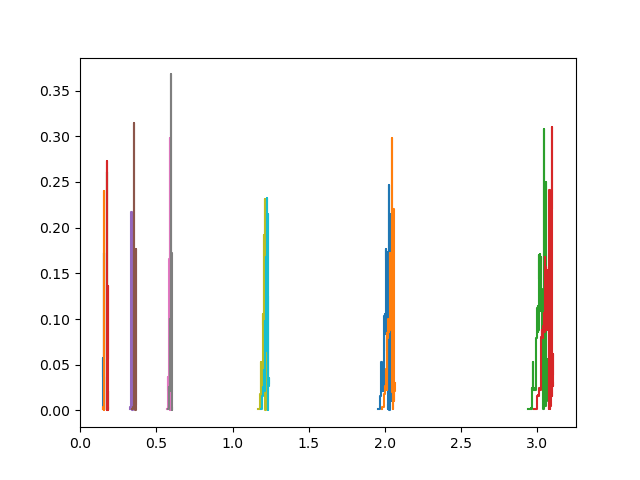

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
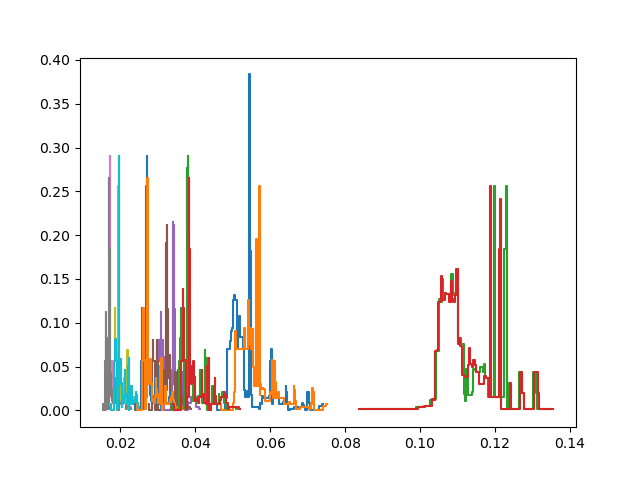

In [78]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        continue
        #frequencies = np.arange(2048)
        all_focals = []
        space_ind = 3
        for freq_ind in range(1025):
            ret_ind = {'frequencies':freq_ind, 'space':space_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            arr = np.load(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
#             poly_uq.load_state(f'/usr/scratch4/sima9999/work/modal_uq/uq_modal/{ret_dir}/polyuq_avg_inc.npz')
            focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']
            all_focals.append(focals_stats)
            
        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(np.stack([foc[0,:,:] for foc in all_focals]),focals_mass)
        n_bins_bel = bel_stats.shape[1]
        cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
        plt.figure()
        im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 5, np.min(focals_stats), np.max(focals_stats)),
                        cmap=cmap, origin='lower')
        
        
    else:
#         continue
#         fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
        fig, ax1 = plt.subplots()
            
        for mode_ind in range(14):
            ret_ind = {'modes':mode_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            
#             poly_uq.load_state(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_lci_inc.npz'))
#             focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
#             if False:
#                 plot_focals(focals_stats[0,:,:], focals_mass, ax2)
#             else:
#                 bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 1, False)
#                 ax2.step(bins_bel, pl_stats[0], where='post',label='plausibility ')
            
            poly_uq.load_state(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
            focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
            
            if False:
                plot_focals(focals_stats[0,:,:], focals_mass, ax1)
            else:
                bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
                ax1.step(bins_bel, pl_stats[0], where='post',label='plausibility ')




            
# plt.step(bins_bel, bel_stats[0], where='post',label='belief')
# plt.step(bins_bel, bel_stats[1], where='post',label='belief')
# plt.step(bins_bel, pl_stats[0], where='post',label='plausibility ')
# plt.step(bins_bel, pl_stats[1], where='post', c='grey')
# plt.step(bins_bel, pl_stats[0], where='post', c='grey')
# plt.fill_between(bins_bel, pl_stats[0], pl_stats[1], step='post',label='plausibility', color='lightgrey')
# plt.step(bins_bel, q_stats[0], where='post',label='commonality')
# plt.legend()
# plt.xlabel(f"{ret_dir}")
# plt.ylabel("mass")
# None

In [ ]:
all_focals_this = np.stack([foc[0,:,:] for foc in all_focals])
# all_focals_this /= np.max(all_focals_this)
all_focals_this[all_focals_this<=1e-3] = 1e-3
all_focals_this[all_focals_this>80] = 80
# all_focals_this = 10*np.log10(all_focals_this)
bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(all_focals_this,focals_mass,1)
np.savez('/usr/scratch4/sima9999/frf_pl.npz', all_focals_this, bel_stats, pl_stats, q_stats, bins_bel)
n_bins_bel = bel_stats.shape[1]
cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
with matplotlib.rc_context(print_context_dict2):
    plt.figure()
    print(np.min(all_focals_this), np.max(all_focals_this))
    im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 200, np.min(all_focals_this), np.max(all_focals_this)),
                    cmap=cmap, origin='lower', vmin=0, vmax=1)
    plt.xlabel('Frequency [\\si{\\hertz}]')
    plt.ylabel('FRF Magnitude [\\si{\\metre\\per\\second\\squared}]')

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_lci_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-1/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-2/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/zetas-0/polyuq_avg_inc.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima99

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
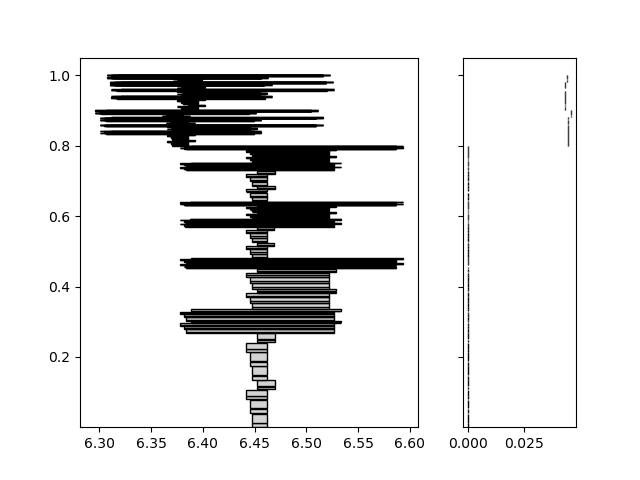

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
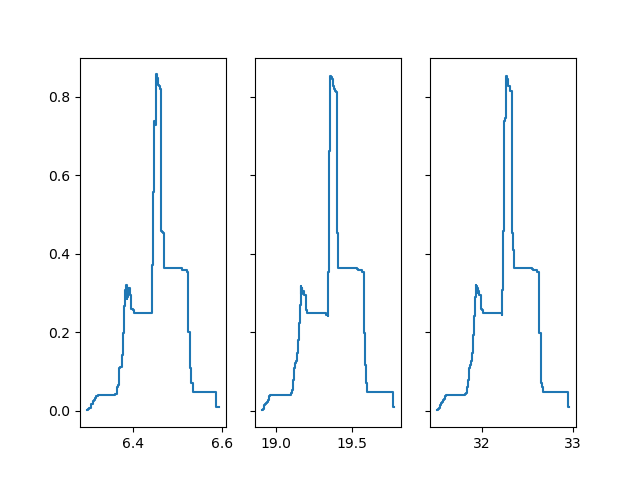

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
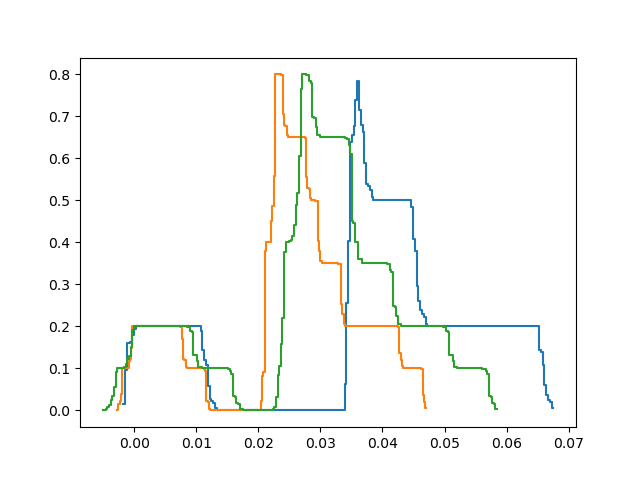

In [19]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

if 0:
    fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
    ret_name='damp_freqs'
    ret_ind = {'modes':0}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_lci_inc.npz'))
    focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
    plot_focals(focals_stats[0,:,:], focals_mass, ax2)

    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
    focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
    plot_focals(focals_stats[0,:,:], focals_mass, ax1)
    
if 1:
    fig, axes = plt.subplots(1,3, sharey=True)
    ret_name='damp_freqs'
    for mode_ind,ax in enumerate(axes):
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        ax.step(bins_bel, pl_stats[0], where='post',label='plausibility')

if 1:
    fig, ax = plt.subplots(1,1, sharey=True)
    ret_name='zetas'
    for mode_ind in range(3):
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        ax.step(bins_bel, pl_stats[0], where='post',label='plausibility')

In [21]:
# ret_name = 'frf'
# space_ind = 9
# freq_ind = 100
# ret_ind = {'frequencies':freq_ind, 'space':space_ind}
ret_name = 'damp_freqs'
# ret_name = 'zetas'
mode_ind = 0
ret_ind = {'modes':mode_ind}

ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

if True:
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_imp.npz'))
    
    def stat_fun(a, weight, i_stat, bins_densities, cum_dens):
        '2. Quantify Variability for each incomplete sample and imprecise hypercube'
        if i_stat is None:
            hist,_ = np.histogram(a, bins_densities, weights=weight, density=True)

            if cum_dens:
                hist= np.cumsum(hist)
                hist /= hist[-1]   
            return hist
        else:
            # factor 6 faster but more error prone for "dirty" data, uneven bins or ....
            if cum_dens: first_edge = bins_densities[0]
            else: first_edge = bins_densities[i_stat]
            last_edge = bins_densities[i_stat + 1]
            keep  = (a >= first_edge)
            keep &= (a <=  last_edge)
            return np.sum(weight[keep])


    nbin_fact=20
    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
    n_stat = len(bins_densities) - 1
    cum_dens = False
    stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}

    # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
    focals_stats, focals_mass = poly_uq.optimize_inc(stat_fun, n_stat, stat_fun_kwargs)
    # poly_uq.save_state(os.path.join(result_dir,f'{ret_dir}/polyuq_hist_inc.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,f'{ret_dir}/polyuq_hist_inc.npz'))
    
    nbin_fact=20
    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
    cum_dens = True
    
    focals_stats = poly_uq.focals_stats
    focals_mass = poly_uq.focals_mass

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal/omegans-0/polyuq_imp.npz
INFO:uncertainty.polymorphic_uncertainty:Estimating incompleteness intervals by direct L-BFGS optimization of statistics over input hypercubes...


/usr/wrk/people9/sima9999/my-python/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


....................................................................................................


In [24]:
focals_stats = focals_densities
focals_mass = hyc_mass
bel_densities, pl_densities, q_densities, bins_bel = aggregate_mass(focals_stats, focals_mass, 20, False)
n_bins_bel = bel_densities.shape[1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
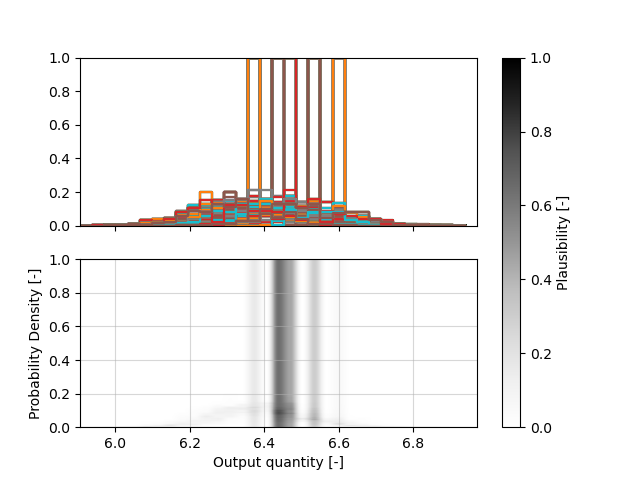

In [25]:

bpq=2

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)   

for i_hyc in range(hyc_mass.shape[0]):
    l2d=ax1.step(bins_densities[:-1], focals_stats[:,i_hyc, 0], where='post')
    c = l2d[0].get_color()
    ax1.step(bins_densities[:-1], focals_stats[:,i_hyc, 1], where='post', color=c)

if bpq == 1:
    belief = bel_densities.T
    label = 'Belief [-]'
elif bpq == 2:
    belief = pl_densities.T
    label = 'Plausibility [-]'
elif bpq == 3:
    belief = q_densities.T
    label = 'Commonality [-]'

cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
im = ax2.imshow(belief, aspect='auto', extent= (bins_densities[0], bins_densities[-1], 0, 1), 
           cmap=cmap, origin='lower', vmin=0, vmax=1)

cbar = fig.colorbar(im, ax=[ax1,ax2])
cbar.set_label(label)

ax2.grid(True, alpha=0.5)
ax2.set_xlabel("Output quantity [-]")

if cum_dens:
    ax2.set_ylabel("Cumulative Probability Density [-]")
else:
    ax2.set_ylabel("Probability Density [-]")    

### distributed quantification (ray) ###

In [5]:
ray.shutdown()
ray.init(address='auto', _redis_password='5241590000000000')

2023-02-03 08:20:36,748	INFO worker.py:1342 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-02-03 08:20:36,758	INFO worker.py:1519 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


RayContext(dashboard_url='141.24.193.47:5990', python_version='3.10.8', ray_version='2.1.0', ray_commit='be49bde7ee4f6adb3f8710aee0665c27f9f0bb62', address_info={'node_ip_address': '141.24.193.47', 'raylet_ip_address': '141.24.193.47', 'redis_address': None, 'object_store_address': '/usr/tmp/ray/session_2023-02-01_11-44-04_182790_30395/sockets/plasma_store', 'raylet_socket_name': '/usr/tmp/ray/session_2023-02-01_11-44-04_182790_30395/sockets/raylet', 'webui_url': '141.24.193.47:5990', 'session_dir': '/usr/tmp/ray/session_2023-02-01_11-44-04_182790_30395', 'metrics_export_port': 62732, 'gcs_address': '141.24.193.47:6379', 'address': '141.24.193.47:6379', 'dashboard_agent_listen_port': 52365, 'node_id': '9643a82e4cba5094763b69d37023674d711c4045c2bfe69a69474f7d'})

In [ ]:
@ray.remote(num_cpus=4)
def remot_est_imp(ret_name, ret_ind):
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
    
    if os.path.exists(imp_path):
        ploy_uq.load_state(imp_path)
    elif os.path.exists(prop_path):
        poly_uq.load_state(prop_path)
    else:
        raise RuntimeError("Paths do not exists")
    
    if poly_uq.imp_foc is not None:
        start_ale = np.min(
            np.nonzero(
                np.any(
                    np.isnan(poly_uq.imp_foc[:,:,0]),
                    axis=1)
            )[0]
        )
    else:
        start_ale = 0
    while start_ale < 3062:
        end_ale = min(start_ale + 100, 3062)
        poly_uq.estimate_imp(
            interp_fun='rbf',
            opt_meth='genetic',
            plot_res=False,
            plot_intp=False,
            intp_err_warn = 20,
            extrp_warn = 10,
            start_ale = start_ale,
            end_ale = end_ale,
            kernel='gaussian',
            epsilon={'frf':4,'zetas':2,'damp_freqs':2}[ret_name]
        )
        poly_uq.save_state(imp_path)
        start_ale = end_ale

In [16]:
@ray.remote
def remote_opt_inc(ret_name, ret_ind):
    
    def stat_fun_hist(a, weight, i_stat, bins_densities, cum_dens):
        '2. Quantify Variability for each incomplete sample and imprecise hypercube'
        if i_stat is None:
            hist,_ = np.histogram(a, bins_densities, weights=weight, density=True)

            if cum_dens:
                hist= np.cumsum(hist)
                hist /= hist[-1]   
            return hist
        else:
            # factor 6 faster but more error prone for "dirty" data, uneven bins or ....
            if cum_dens: first_edge = bins_densities[0]
            else: first_edge = bins_densities[i_stat]
            last_edge = bins_densities[i_stat + 1]
            keep  = (a >= first_edge)
            keep &= (a <=  last_edge)
            return np.sum(weight[keep])
    
    def stat_fun_avg(a, weight,i_stat):
        return np.average(a, weights=weight)

    def stat_fun_ci(a, weight, i_stat):
        n = len(a)
        mean = np.average(a, weights=weight)
        std = np.sqrt(np.cov(a, aweights=weight))
        if std==0:
            conf= [mean, mean]
        else:
            sem = std / np.sqrt(n)
            conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
        if i_stat is not None:
            return conf[i_stat]
        else: 
            return conf
        
    def stat_fun_lci(a, weight, i_stat):
        n = len(a)
        mean = np.average(a, weights=weight)
        std = np.sqrt(np.cov(a, aweights=weight))
        if std==0:
            conf= [mean, mean]
        else:
            sem = std / np.sqrt(n)
            conf = scipy.stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=sem) 
        return conf[1]-conf[0]

    
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    poly_uq.load_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
    
    if False:
        nbin_fact=20
        n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
        bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
        n_stat = len(bins_densities) - 1
        cum_dens = True
        stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_hist, n_stat, stat_fun_kwargs)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_hist_inc.npz'))
    if True:
        n_stat = 1
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_avg, n_stat,)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_avg_inc.npz'))
    if False:
        n_stat = 2
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_ci, n_stat,)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_ci_inc.npz'))
    if False:
        n_stat = 1
        # focals_densities, hyc_mass = poly_uq.estimate_inc(intervals, stat_fun, n_stat, stat_fun_kwargs)
        focals_densities, hyc_mass = poly_uq.optimize_inc(stat_fun_lci, n_stat,)
        poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_lci_inc.npz'))
    

In [ ]:
logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)

def submit_imp():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
    if not os.path.exists(fname) or True:
        futures.append(remot_est_imp.remote(ret_name, ret_ind))
    else:
        print(f'{ret_dir}/polyuq_imp.npz already finished.')
        

def submit_inc():
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    fname = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_avg_inc.npz')
    if not os.path.exists(fname):
        futures.append(remote_opt_inc.remote(ret_name, ret_ind))
    else:
        print(f'{ret_dir}/polyuq_avg_inc.npz already finished.')
        
def submit():
    submit_imp()
    # submit_inc()
if True:
    futures = list(futures)
else:
    futures = []
ret_name = 'frf'
for ret_name in ['damp_freqs','zetas','frf']:
    if ret_name == 'frf':
        for freq_ind in range(127,205):
            for space_ind in [1,]:
                ret_ind = {'frequencies':freq_ind, 'space':space_ind}
                submit()
    else:
        continue
        for mode_ind in range(14):
            ret_ind = {'modes':mode_ind}
            submit()
futures = set(futures)

In [ ]:
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=180)
    finished = []
    failed = []
    for obj_ref in ready:
        try:
            ret_sets = ray.get(obj_ref)
            finished.append(obj_ref)
        except ray.exceptions.RayTaskError as e:
            print(e)
            failed.append(obj_ref)
    
    size_before = len(futures)
    futures.difference_update(finished)
    futures.difference_update(failed)
    print(f"Finished {len(finished)}, failed {len(failed)} samples. Remaining {len(futures)} samples. (before {size_before})")
        
    if len(futures) == 0:
        break

(remot_est_imp pid=21978, ip=141.24.193.102) Progress: 48.00239494883519 %
(remot_est_imp pid=16285, ip=141.24.193.161) Progress: 43.00021772262138 %
(remot_est_imp pid=26062, ip=141.24.193.178) WARNING:uncertainty.polymorphic_uncertainty:Extrapolation by 14.388 percent (interpolation domain min) at sample 1571 hypercube 2.
(remot_est_imp pid=9878, ip=141.24.193.177) Progress: 57.002503810145875 %
(remot_est_imp pid=10225, ip=141.24.193.169) Progress: 53.00185064228173 %
(remot_est_imp pid=10132, ip=141.24.193.169) Progress: 53.00185064228173 %
(remot_est_imp pid=10148, ip=141.24.193.177) Progress: 54.000653167864144 %
(remot_est_imp pid=16524, ip=141.24.193.161) WARNING:uncertainty.polymorphic_uncertainty:RMSE of interpolator using 100 runs of leave-one-out cross-validation: 21.424 percent
(remot_est_imp pid=9872, ip=141.24.193.177) Progress: 54.000653167864144 %
(remot_est_imp pid=7457, ip=141.24.193.157) WARNING:uncertainty.polymorphic_uncertainty:Extrapolation by 17.086 percent (in

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
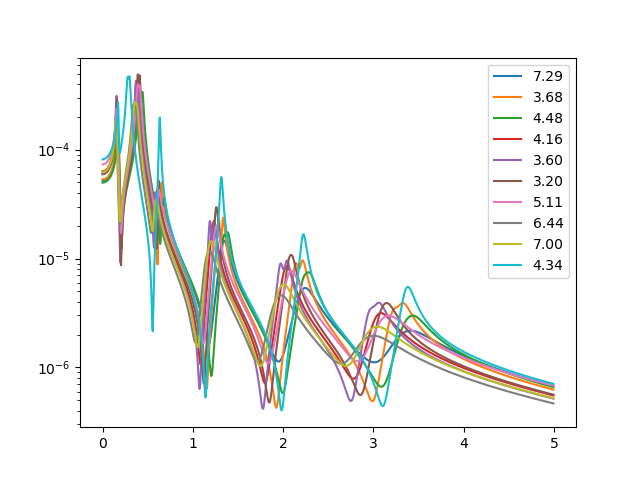

In [109]:
dm_grid = DataManager.from_existing('uq_modal_beam.nc',
                                    os.path.join(result_dir, 'samples'), 
                                    working_dir='/dev/shm/womo1998/')
plt.figure()
with dm_grid.get_database('in') as in_ds:
    for _ in range(10):
        jid=np.random.choice(in_ds.ids)
        savefolder = os.path.join(result_dir, 'samples', jid)
        arr = np.load(os.path.join(savefolder, f'{jid}_mechanical.npz'))
        
        plt.plot(arr['self.omegas']/2/np.pi,np.abs(arr['self.frf'][:,-1]), label=f'{np.mean(arr["self.modal_damping"]*100):1.2f}')
plt.yscale('log')
plt.legend()
# plt.xlim((0,10))
plt.show()